In [1]:
# Inspired by: https://towardsdatascience.com/make-a-simple-nba-shot-chart-with-python-e5d70db45d0d

from nba_api.stats.endpoints import shotchartdetail, commonteamroster
from nba_api.stats.static import teams
import pandas as pd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

In [2]:
teams_list = teams.get_teams()
teams_dict = dict([(x['abbreviation'], None) for x in teams_list])
print([x['abbreviation'] for x in teams_list])

['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL', 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']


In [144]:
season = '2022-23' # Keep this format
start_date = datetime.datetime.strptime('2023-03-01', '%Y-%m-%d') # YYYY-MM-DD format
end_date = datetime.datetime.strptime('2023-03-25', '%Y-%m-%d') # YYYY-MM-DD format
team_abbr = 'PHI' # Choose one of the teams from the list in the cell above
player_name = 'Joel Embiid' # Choose a player from the selected team
season_type = 'Regular Season' # ^(Regular Season)|(Pre Season)|(Playoffs)|(All Star)$
chart_type = 'Volume' # 'Volume' or 'Distribution'

In [145]:
def get_team_id(abbreviation):
    results = [x['id'] for x in teams_list if x['abbreviation'] == abbreviation]
    if len(results) > 0:
        return results[0]
    return None

def get_team_roster(team_abbr):
    team_id = get_team_id(team_abbr)
    roster = commonteamroster.CommonTeamRoster(season=season, team_id=team_id)
    roster_loaded = json.loads(roster.get_json())
    headers = roster_loaded['resultSets'][0]['headers']
    rows = roster_loaded['resultSets'][0]['rowSet']
    roster_df = pd.DataFrame(rows, columns = headers)
    teams_dict[team_abbr] = roster_df
    print(headers)
    

def get_player_id(team_abbr, name = None):
    if teams_dict[team_abbr] is None:
        get_team_roster(team_abbr)
    roster_df = teams_dict[team_abbr]
    player_data = roster_df.loc[roster_df['PLAYER'] == name].iloc[0]
    return player_data['PLAYER_ID']

In [146]:
shot_json = shotchartdetail.ShotChartDetail(
            team_id = get_team_id(team_abbr),
            player_id = get_player_id(team_abbr, player_name),
            context_measure_simple = 'FGA',
            season_nullable = season,
            season_type_all_star = season_type)

['TeamID', 'SEASON', 'LeagueID', 'PLAYER', 'NICKNAME', 'PLAYER_SLUG', 'NUM', 'POSITION', 'HEIGHT', 'WEIGHT', 'BIRTH_DATE', 'AGE', 'EXP', 'SCHOOL', 'PLAYER_ID', 'HOW_ACQUIRED']


In [147]:
shot_json_loaded = json.loads(shot_json.get_json())

In [148]:
headers = shot_json_loaded['resultSets'][0]['headers']
rows = shot_json_loaded['resultSets'][0]['rowSet']
print(headers)

['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM']


In [149]:
player_data = pd.DataFrame(rows, columns = headers)
player_data['GAME_DATE'] = pd.to_datetime(player_data['GAME_DATE'])
player_data.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022200001,7,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,11,38,...,Left Side(L),8-16 ft.,12,-118,50,1,0,2022-10-18,BOS,PHI
1,Shot Chart Detail,0022200001,17,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,10,33,...,Right Side Center(RC),24+ ft.,26,116,241,1,0,2022-10-18,BOS,PHI
2,Shot Chart Detail,0022200001,203,203954,Joel Embiid,1610612755,Philadelphia 76ers,2,11,33,...,Center(C),16-24 ft.,17,7,174,1,1,2022-10-18,BOS,PHI
3,Shot Chart Detail,0022200001,236,203954,Joel Embiid,1610612755,Philadelphia 76ers,2,9,9,...,Left Side Center(LC),24+ ft.,27,-174,218,1,0,2022-10-18,BOS,PHI
4,Shot Chart Detail,0022200001,286,203954,Joel Embiid,1610612755,Philadelphia 76ers,2,4,17,...,Right Side Center(RC),24+ ft.,26,134,226,1,1,2022-10-18,BOS,PHI


In [150]:
player_data_filtered = player_data.loc[(player_data['GAME_DATE'] > start_date) & (player_data['GAME_DATE'] < end_date)]
player_data_filtered.tail()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
1211,Shot Chart Detail,0022201103,566,203954,Joel Embiid,1610612755,Philadelphia 76ers,4,6,37,...,Left Side(L),16-24 ft.,16,-162,38,1,1,2023-03-24,GSW,PHI
1212,Shot Chart Detail,0022201103,576,203954,Joel Embiid,1610612755,Philadelphia 76ers,4,5,32,...,Center(C),Less Than 8 ft.,4,-31,31,1,1,2023-03-24,GSW,PHI
1213,Shot Chart Detail,0022201103,588,203954,Joel Embiid,1610612755,Philadelphia 76ers,4,4,35,...,Center(C),Less Than 8 ft.,2,-4,25,1,1,2023-03-24,GSW,PHI
1214,Shot Chart Detail,0022201103,607,203954,Joel Embiid,1610612755,Philadelphia 76ers,4,2,6,...,Left Side(L),8-16 ft.,10,-58,90,1,0,2023-03-24,GSW,PHI
1215,Shot Chart Detail,0022201103,611,203954,Joel Embiid,1610612755,Philadelphia 76ers,4,1,34,...,Right Side(R),8-16 ft.,11,88,74,1,0,2023-03-24,GSW,PHI


In [155]:
# Function to draw basketball court
def create_court(ax, color):
    
    ax.fill_between((-250, 250), (0, 40000), color='#f9c852')
    
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))

    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    
    ax.text(0, 1.05, '{}\n{} {}\n{} - {}\nShot {}'.format(player_name, season, season_type, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), chart_type), transform=ax.transAxes, ha='left', va='baseline')

    if chart_type == 'Volume':
        pass
        ax.hexbin(player_data_filtered['LOC_X'], player_data_filtered['LOC_Y'] + 60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='Blues')
    else:
        for index, row in player_data_filtered.iterrows():
            if row['SHOT_MADE_FLAG']:
                circle = plt.Circle((row['LOC_X'], row['LOC_Y'] + 60), color = 'b')
                ax.add_artist(circle)
            else:
                circle = plt.Circle((row['LOC_X'], row['LOC_Y'] + 60), color = 'r')
                ax.add_artist(circle)

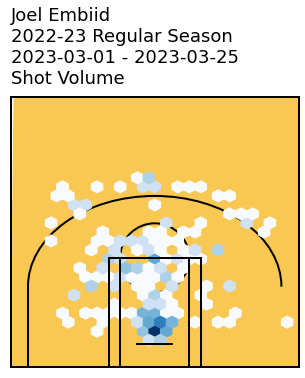

In [156]:
# General plot parameters
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2

# Draw basketball court
fig = plt.figure(figsize=(4, 3.76))
ax = fig.add_axes([0, 0, 1, 1])
ax = create_court(ax, 'black')

title = "{}-{}".format(player_name, season)    
plt.savefig(title + '.jpg', dpi=1000)

plt.show()